# Analyzing Rat snATAC-seq

## Setup

Get the paths to the files and set our working directory.

In [1]:
sample = "data/10x/Rat_Amygdala_cocaine_high/outs"

# Files from CellRanger:
# 1) peak/cell matrix - counts of the Tn5 cut sites within each peak
raw = paste0(sample, "/filtered_peak_bc_matrix.h5")
# 2) some metadata
metadata = paste0(sample, "/singlecell.csv")
# 3) a list of unique fragments across all single cells
fragments = paste0(sample, "/fragments.tsv.gz")

In [2]:
# change to the data/.. dir
setwd("..")

In [3]:
# set the plot sizes to be full width
library(repr)
# Change plot size to BIG
options(repr.plot.width=20, repr.plot.height=10)

Load our dependencies.

Note that this notebook is being run from within a conda environment. You can use our [`env.yml` file](/snATAC/env.yml) to reproduce it.

In [4]:
suppressMessages(library(Signac))
suppressMessages(library(Seurat))
suppressMessages(library(GenomeInfoDb))
# suppressMessages(library(BSgenome.Rnorvegicus.UCSC.rn6))
suppressMessages(library(ggplot2))
suppressMessages(library(patchwork))
suppressMessages(library(AnnotationHub))

Get rat annotations. We use ensemblDB's annotation hub to get this.

In [5]:
EnsDb.Rnorvegicus.v98 = query(AnnotationHub(), pattern = c("Rattus Norvegicus", "EnsDb", 98))[[1]]

using temporary cache /tmp/RtmpVSluW2/BiocFileCache

snapshotDate(): 2020-04-27

downloading 1 resources

retrieving 1 resource

loading from cache

require(“ensembldb”)



In [6]:
counts = Read10X_h5(filename = raw)
metadata = read.csv(
  file = metadata,
  header = TRUE,
  row.names = 1
)

In [7]:
amygdala = CreateSeuratObject(
  counts = counts,
  assay = 'peaks',
  project = 'ATAC',
  min.cells = 1,
  meta.data = metadata
)

Warning message in CreateSeuratObject.default(counts = counts, assay = "peaks", :
"Some cells in meta.data not present in provided counts matrix"


In [8]:
fragment.path = fragments
amygdala = SetFragments(
  object = amygdala,
  file = fragment.path
)
amygdala

An object of class Seurat 
67446 features across 13506 samples within 1 assay 
Active assay: peaks (67446 features, 0 variable features)

## Computing QC Metrics

In [9]:
# note we currently only do this for chr1 because it can take a while
# TODO: change this to the entire genome?
amygdala <- NucleosomeSignal(object = amygdala, region = "1-1-282763074")

Extracting reads in requested region

Computing ratio of mononucleosomal to nucleosome-free fragments



Next, we calculate the following quality control metrics:
1. `nucleosome_signal` - the approximate ratio of mononucleosomal fragments (147 bp < len < 294 bp) to nucleosome-free fragments (len < 147 bp) for each cell
    - Good cells will have low numbers (less than ~10)
2. `TSS.enrichment` - the ratio of fragments centered at the TSS to fragments in TSS-flanking regions
    - Good cells will have high TSS enrichment scores (> 2)
3. `peak_region_fragments` - total number of fragments in peaks
    - Good cells won't be too high or too low here
    - Low numbers represent cells with low sequencing depth and high numbers represent doublets or nuclear clumps
4. `pct_reads_in_peaks` - fraction of fragments in peaks
    - Good cells will have high values (> 15-20%)

Note that we don't calculate the ratio of reads in blacklist sites because ENCODE hasn't done this for rats yet.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
"Removed 116 rows containing non-finite values (stat_ydensity)."
Warning message:
"Removed 116 rows containing missing values (geom_point)."
Warning message:
"Removed 300 rows containing non-finite values (stat_ydensity)."
Warning message:
"Removed 293 rows containing missing values (geom_point)."


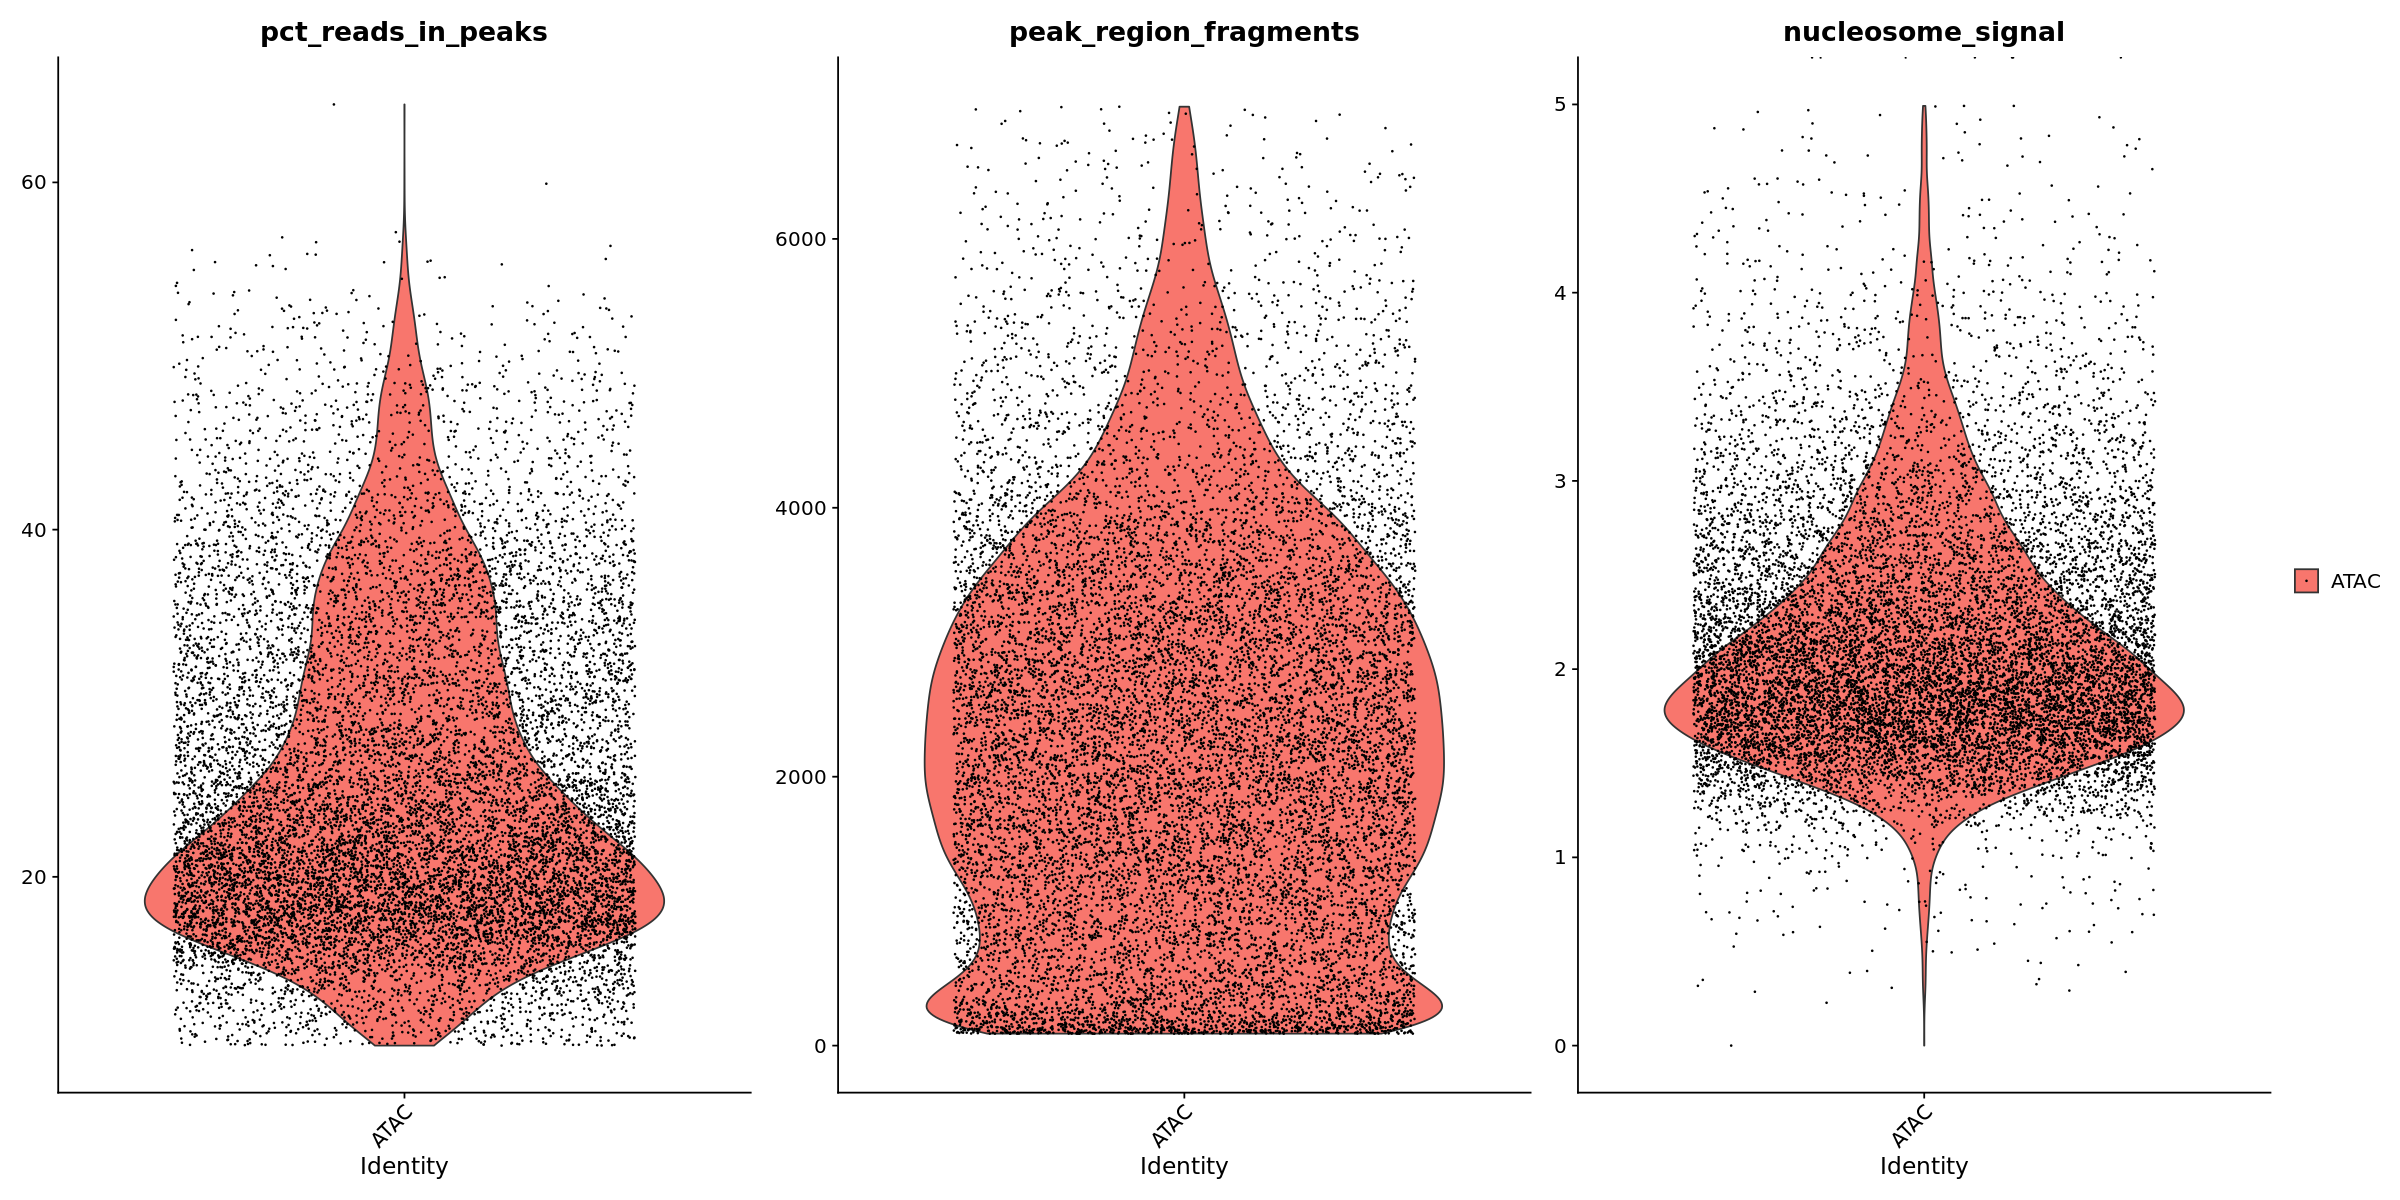

In [10]:
amygdala$pct_reads_in_peaks <- amygdala$peak_region_fragments / amygdala$passed_filters * 100

p1 <- VlnPlot(amygdala, c('pct_reads_in_peaks'), pt.size = 0.1) + NoLegend()
p2 <- VlnPlot(amygdala, c('peak_region_fragments'), pt.size = 0.1) + NoLegend() + ylim(0, 7000)
p3 <- VlnPlot(amygdala, c('nucleosome_signal'), pt.size = 0.1, y.max=20) + ylim(0,5)

p1 | p2 | p3

Let's get rid of cells with a high `nucleosome_signal` and plot the histogram of fragments for the others.

Warning message:
"Removed 37193 rows containing non-finite values (stat_bin)."
Warning message:
"Removed 4 rows containing missing values (geom_bar)."


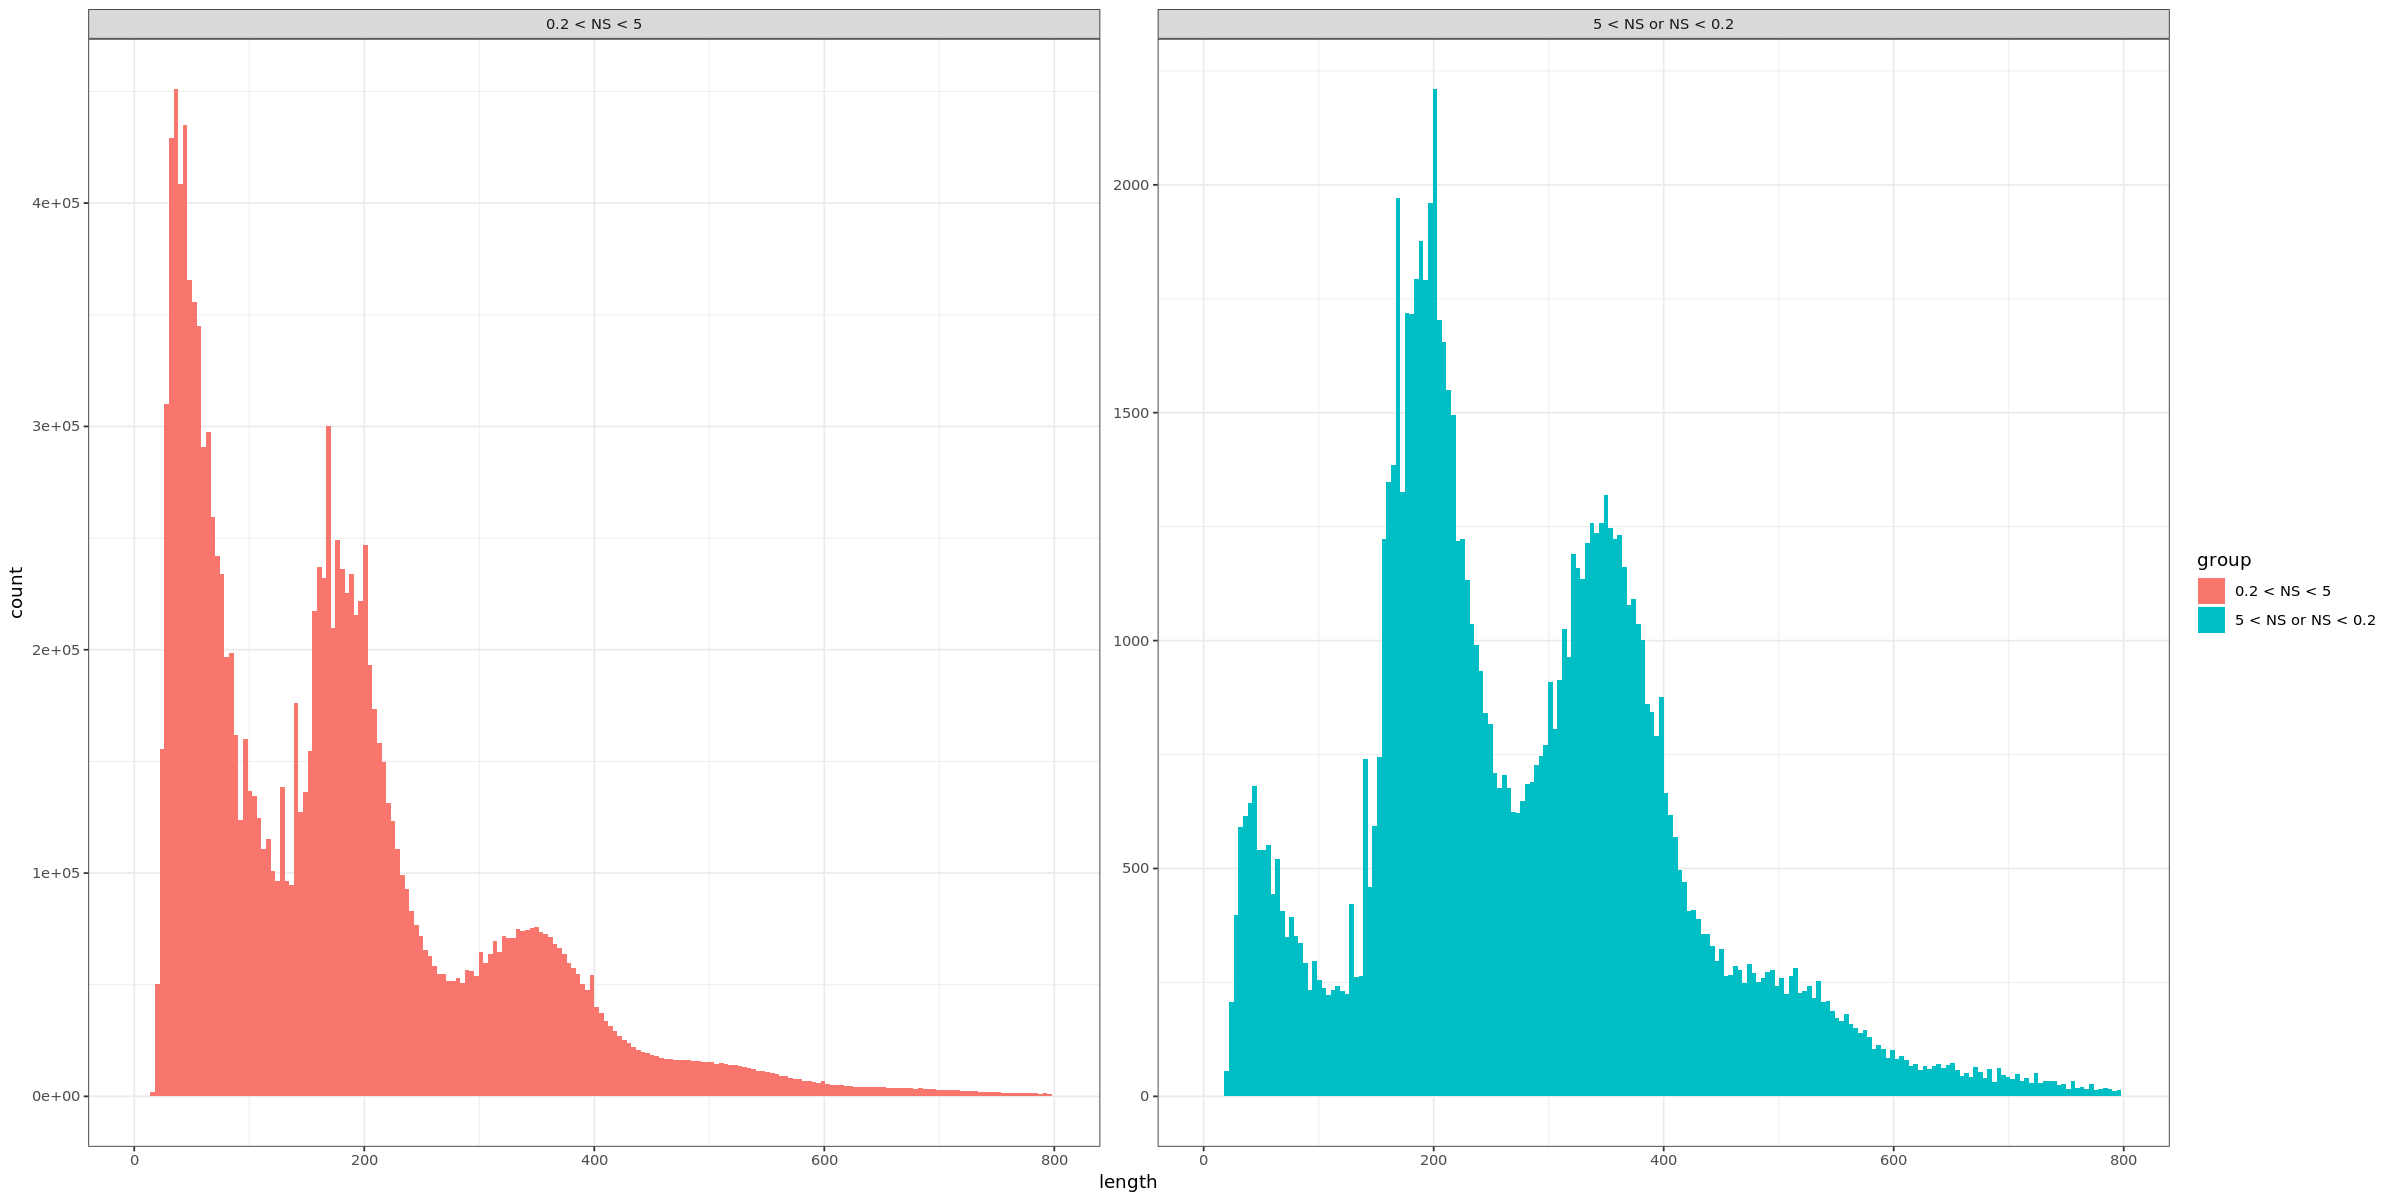

In [11]:
amygdala$nucleosome_group <- ifelse(5 < amygdala$nucleosome_signal | amygdala$nucleosome_signal < 0.2, '5 < NS or NS < 0.2', '0.2 < NS < 5')
# TODO: change the region from chr1 to something more useful
FragmentHistogram(object = amygdala, group.by = 'nucleosome_group', region='1-1-282763074')

Now, we can calculate the TSS enrichment score for each cell.

In [ ]:
# create granges object with TSS positions
# not sure which reference genome is the right one to use here, but I chose Rnorvegicus from EnsDB
# we grab the TSS positions from the reference genome
gene.ranges <- genes(EnsDb.Rnorvegicus.v98)
gene.ranges <- gene.ranges[gene.ranges$gene_biotype == 'protein_coding',]
gene.ranges <- keepStandardChromosomes(gene.ranges, pruning.mode = 'coarse', species='Rattus_norvegicus')

tss.ranges <- resize(gene.ranges, width = 1, fix = "start")
# drop the mt genome because it is not in our tabix index
tss.ranges <- dropSeqlevels(tss.ranges, "MT", pruning.mode = 'coarse')
tss.ranges <- keepStandardChromosomes(tss.ranges, pruning.mode = 'coarse', species='Rattus_norvegicus')
amygdala <- TSSEnrichment(object = amygdala, tss.positions = tss.ranges)

In [ ]:
amygdala$high.tss <- ifelse(amygdala$TSS.enrichment > 2, 'High', 'Low')
TSSPlot(amygdala, group.by = 'high.tss') + ggtitle("TSS enrichment score") + NoLegend()

Now, we use our analysis to choose some cutoff values for the QC metrics.

In [ ]:
amygdala <- subset(
  x = amygdala,
  subset = peak_region_fragments > 600 &
    peak_region_fragments < 6000 &
    pct_reads_in_peaks > 10 &
    nucleosome_signal < 5 &
    nucleosome_signal > 0.2 &
    TSS.enrichment > 2
)
amygdala

## Normalization and linear dimensional reduction

Run SVD (single value decomposition) to reduce the matrix to a low-dimensional representation. We can use the SVD output to make our UMAP plot. This is like performing PCA prior to t-SNE.

In [ ]:
amygdala <- RunTFIDF(amygdala)
amygdala <- FindTopFeatures(amygdala, min.cutoff = 'q0')
amygdala <- RunSVD(
  object = amygdala,
  assay = 'peaks',
  reduction.key = 'LSI_',
  reduction.name = 'lsi'
)

In [ ]:
DepthCor(amygdala)

We ignore the first component because it has a high correlation, likely because of technical artifacts.

In [ ]:
amygdala <- RunUMAP(object = amygdala, reduction = 'lsi', dims = 2:30)
amygdala <- FindNeighbors(object = amygdala, reduction = 'lsi', dims = 2:30)
amygdala <- FindClusters(object = amygdala, verbose = FALSE, algorithm = 3)
DimPlot(object = amygdala, label = TRUE) + NoLegend()

## Create a gene activity matrix

In [ ]:
# Extend coordinates upstream to include the promoter
genebodyandpromoter.coords <- Extend(x = gene.ranges, upstream = 2000, downstream = 0)

# create a gene by cell matrix
gene.activities <- FeatureMatrix(
  fragments = fragment.path,
  features = genebodyandpromoter.coords,
  cells = colnames(amygdala),
  chunk = 20
)

# convert rownames from chromsomal coordinates into gene names
gene.key <- genebodyandpromoter.coords$gene_name
names(gene.key) <- GRangesToString(grange = genebodyandpromoter.coords)
rownames(gene.activities) <- gene.key[rownames(gene.activities)]

In [ ]:
# add the gene activity matrix to the Seurat object as a new assay, and normalize it
amygdala[['RNA']] <- CreateAssayObject(counts = gene.activities)
amygdala <- NormalizeData(
  object = amygdala,
  assay = 'RNA',
  normalization.method = 'LogNormalize',
  scale.factor = median(amygdala$nCount_RNA)
)

In [ ]:
DefaultAssay(amygdala) <- 'RNA'

FeaturePlot(
  object = amygdala,
  features = c('MS4A1', 'CD3D', 'LEF1', 'NKG7', 'TREM1', 'LYZ'),
  pt.size = 0.1,
  max.cutoff = 'q95',
  ncol = 3
)

# Integrating with scRNA-seq data